# Scripts related to venv
### Open a terminal
- .venv\Scripts\activate
- py -m pip install --upgrade pip
- py -m pip install requests
- py -m pip freeze > requirements.txt
- py -m pip install -r requirements.txt

# AWS Article
- https://induraj2020.medium.com/how-to-access-the-s3-bucket-using-python-ecdbe5ebc45f

# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN 

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [1]:
import os
import librosa
import boto3
import math
import json
import matplotlib.pyplot as plt
import io
import numpy as np
import warnings 
import requests
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
dataset_path = r"Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [3]:
def save_mfcc(bucket_name, dataset_path, json_path, n_mfcc=13, n_fft=2048,
                 hop_length=512, num_segments=5):
    # Initialize S3 client
    s3 = boto3.client('s3')
    
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)  # ps = per segment
    expected_vects_ps = math.ceil(samples_ps / hop_length)
    
    # Paginator to handle large lists of objects
    paginator = s3.get_paginator('list_objects_v2')
    
    # Loop through each "genre" folder in S3
    for i, page in enumerate(paginator.paginate(Bucket=bucket_name, Prefix=dataset_path)):
        if 'Contents' not in page:
            continue

        for obj in page['Contents']:
            file_key = obj['Key']
            # Filter to include only `.wav` files and exclude specific files
            if file_key.endswith(".wav") and not file_key.endswith("jazz.00054.wav"):
                # Split to get the genre label
                path_parts = file_key.split('/')
                if len(path_parts) < 2:
                    continue
                genre_label = path_parts[-2]
                
                if genre_label not in data["mapping"]:
                    data["mapping"].append(genre_label)
                    print(f"Processing genre: {genre_label}")

                # Load audio file from S3
                audio_data = s3.get_object(Bucket=bucket_name, Key=file_key)['Body'].read()
                signal, sr = librosa.load(io.BytesIO(audio_data), sr=SAMPLE_RATE)

                # Process each segment
                for s in range(num_segments):
                    start_sample = samples_ps * s
                    finish_sample = start_sample + samples_ps

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft=n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length)

                    mfcc = mfcc.T  # Transpose for easier storage

                    # Store MFCC if it has expected length
                    if len(mfcc) == expected_vects_ps:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(data["mapping"].index(genre_label))
                        print(f"{file_key}, segment: {s+1}")

    # Save the data to a JSON file locally

    s3.put_object(
        Bucket=bucket_name,
        Key="Data/",
        Body=json.dumps(data),
        ContentType='application/json'
    )


In [4]:
from IPython.display import clear_output

In [9]:
save_mfcc(bucket_name='flights12345', dataset_path=dataset_path, json_path=json_path, num_segments=10)
clear_output()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. I have also done splitting in the ratio 70:30

The model is Sequential and architecture only has Flatten and the Dense layers available in keras for the basic ANN representation. As it is naive model we can expect it to be overfit. Info on the layers can be found [here](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/)

In [5]:
# load data
def load_data(dataset_path):
    data = requests.get(dataset_path).json()
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    
    return inputs,targets

In [6]:
inputs, targets = load_data("https://flights12345.s3.us-east-1.amazonaws.com/Data/data.json")

In [16]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import * 

In [18]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [20]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [21]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [22]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 2000x1500 with 0 Axes>

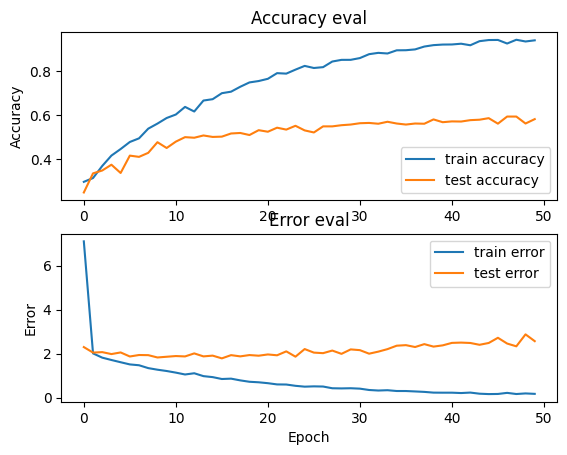

In [23]:
plot_history(hist)

In [24]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5862 - loss: 2.5494
Test accuracy: 0.5807743668556213


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated 
- Using augmented data
- Early stopping of training
- Adding dropout layers
- Regularization / Standardization  

I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30%
Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found [here](https://medium.com/@robertjohn_15390/regularization-in-tensorflow-using-keras-api-48aba746ae21)

In [25]:
import tensorflow.keras as keras

In [26]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,978 (3.88 MB)

 Trainable params: 1,015,978 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
optimizer = optimizers.Adam()
optimizer.build(model.trainable_variables)

model.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])


hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

<Figure size 2000x1500 with 0 Axes>

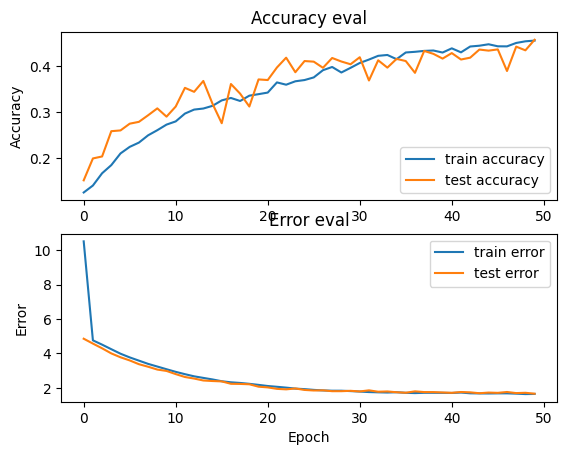

In [28]:
plot_history(hist)

In [29]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4657 - loss: 1.6464
Test accuracy: 0.457610160112381


We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

In [33]:
def prepare_dataset(test_size, validation_size):
    X, y = load_data("https://flights12345.s3.us-east-1.amazonaws.com/Data/data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [34]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [35]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [36]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 1, 16)      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 1, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [37]:
optimizer = optimizers.Adam()
optimizer.build(model.trainable_variables)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.2823 - loss: 2.0841 - val_accuracy: 0.3571 - val_loss: 1.9293
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5027 - loss: 1.4169 - val_accuracy: 0.5300 - val_loss: 1.2986
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5685 - loss: 1.2131 - val_accuracy: 0.5874 - val_loss: 1.1625
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6073 - loss: 1.1170 - val_accuracy: 0.6308 - val_loss: 1.0084
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6455 - loss: 0.9960 - val_accuracy: 0.5461 - val_loss: 1.3415
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6720 - loss: 0.9348 - val_accuracy: 0.6889 - val_loss: 0.9000
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6864 - loss: 0.8832 - val_accuracy: 0.6569 - val_loss: 1.0275
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6904 - loss: 0.8629 - val_accu

<Figure size 2000x1500 with 0 Axes>

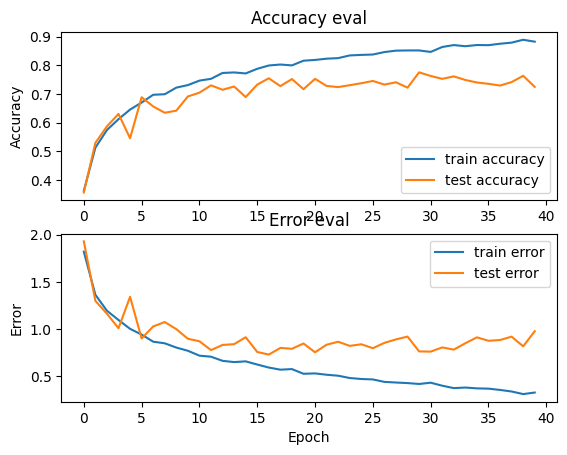

In [38]:
plot_history(hist)

In [39]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7369 - loss: 0.8939
Test accuracy: 0.743291974067688


In [40]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [41]:
predict(model, X_test[10], y_test[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Expected index: 6, Predicted index: [6]


As we can see the accuracy has improved by Significant amount but still the accuracy is not enough, in the future of this notebook I am planning to implement RNN model in this and finally use the ensembling to get a push in accuracy. However any other suggestions are always invited!